In [1]:
import pandas as pd
import glob
import os, sys, re
from tqdm.auto import tqdm
import datetime as dt
import numpy as np

from IPython.display import display, HTML, clear_output
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import warnings

%matplotlib inline

START_TS = dt.datetime.now()


In [2]:
import platform
platform.system()

'Windows'

In [3]:
# make sure we use pytorch environment
! conda env list

# conda environments:
#
                         D:\Anaconda3
                         D:\Anaconda3\envs\py37
                         D:\Anaconda3\envs\py37-gpu
                         D:\Anaconda3\envs\py37-nltk
                         D:\Anaconda3\envs\py37-opencv
                         D:\Anaconda3\envs\py37-tfgpu
base                  *  D:\Anaconda3\envs\py37-torch



In [4]:
import os
import sys
import time
import datetime
import argparse
from tqdm.auto import tqdm

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision import transforms
from torch.autograd import Variable
import torch.optim as optim


In [5]:
from models import Darknet
from utils.parse_config import parse_data_config
from utils.utils import load_classes, rescale_boxes


In [6]:
MODEL_DEFINITION = "config\\yolov3.cfg"
DARKNET_WEIGHTS = "weights\\yolov3.weights"
CLASS_NAMES = "data\\coco.names"
IoU_THRESHOLD = 0.5
OBJECT_CONFIDENCE_THRESHOLD = 0.5
NMS_THRESHOLD = 0.4
YOLO_IMAGE_SIZE = 416

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
display(HTML(f"<h2>Device: {str(device).upper()} will be used</h2>"))

In [8]:
class_names = load_classes(CLASS_NAMES)

## Load weights

In [9]:
model = Darknet(MODEL_DEFINITION).to(device)

In [10]:
model.load_darknet_weights(DARKNET_WEIGHTS)

## YOLO v3 model Layers

In [11]:
model

Darknet(
  (module_list): ModuleList(
    (0): Sequential(
      (conv_0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_0): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_0): LeakyReLU(negative_slope=0.1)
    )
    (1): Sequential(
      (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (batch_norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_1): LeakyReLU(negative_slope=0.1)
    )
    (2): Sequential(
      (conv_2): Conv2d(64, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (batch_norm_2): BatchNorm2d(32, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
      (leaky_2): LeakyReLU(negative_slope=0.1)
    )
    (3): Sequential(
      (conv_3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batch_norm_3): BatchNorm2d(64, eps=1e-05, momen

In [12]:
WIDTH_SIZE = 7
FONT_SIZE = 9

## IoU (intersection over union)

In [13]:
def bbox_iou(box1, box2, x1y1x2y2=True):
    """
    Returns the IoU of two bounding boxes: numpy version
    
    """
    if not x1y1x2y2:
        # Transform from center and width to exact coordinates
        b1_x1, b1_x2 = box1[:, 0] - box1[:, 2] / 2, box1[:, 0] + box1[:, 2] / 2
        b1_y1, b1_y2 = box1[:, 1] - box1[:, 3] / 2, box1[:, 1] + box1[:, 3] / 2
        b2_x1, b2_x2 = box2[:, 0] - box2[:, 2] / 2, box2[:, 0] + box2[:, 2] / 2
        b2_y1, b2_y2 = box2[:, 1] - box2[:, 3] / 2, box2[:, 1] + box2[:, 3] / 2
    else:
        # Get the coordinates of bounding boxes
        b1_x1, b1_y1, b1_x2, b1_y2 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
        b2_x1, b2_y1, b2_x2, b2_y2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]
        
    # get the corrdinates of the intersection rectangle
    inter_rect_x1 = np.maximum(b1_x1, b2_x1)
    inter_rect_y1 = np.maximum(b1_y1, b2_y1)
    inter_rect_x2 = np.minimum(b1_x2, b2_x2)
    inter_rect_y2 = np.minimum(b1_y2, b2_y2)
    
    # Intersection area
    inter_area = np.maximum(inter_rect_x2 - inter_rect_x1 + 1, 0) * np.maximum(inter_rect_y2 - inter_rect_y1 + 1, 0)

    # Union Area
    b1_area = (b1_x2 - b1_x1 + 1) * (b1_y2 - b1_y1 + 1)
    b2_area = (b2_x2 - b2_x1 + 1) * (b2_y2 - b2_y1 + 1)
    
    iou = inter_area / (b1_area + b2_area - inter_area + 1e-16)

    return iou


## Non-Maximum-Supression

In [14]:
def xywh2xyxy(t):
    r = t.copy()
    r[..., 0] = t[..., 0] - t[..., 2] / 2
    r[..., 1] = t[..., 1] - t[..., 3] / 2
    r[..., 2] = t[..., 0] + t[..., 2] / 2
    r[..., 3] = t[..., 1] + t[..., 3] / 2
    return r

def non_max_suppression(prediction, conf_thres=0.5, nms_thres=NMS_THRESHOLD):
    prediction[...,:4] = xywh2xyxy(prediction[...,:4])  

    output = [None]   

    image_pred =prediction[0]

    # Filter out confidence scores below threshold
    image_pred = image_pred[image_pred[:, 4] >= conf_thres]   # imape_pred[4] is object_confidence_field

    # Object confidence times class confidence    
    score = image_pred[:, 4] * image_pred[:, 5:].max(1)[0]  #Умножаем object_confidence_field на class_confidence для всех классов и узнаем максимальный скор для класса

    # Sort by it в убывающем порядке
    image_pred = image_pred[(-score).argsort()]

    class_confs = image_pred[:, 5:].max(1, keepdims=True)
    class_preds = np.expand_dims(image_pred[:, 5:].argmax(1),1)

    detections= np.concatenate([image_pred[:,:5], class_confs, class_preds], axis=1)

    # Perform non-maximum suppression
    keep_boxes = []
    while len(detections):
        large_overlap = bbox_iou(np.expand_dims(detections[0, :4], 0), detections[:, :4]) > nms_thres
        label_match = detections[0, -1] == detections[:, -1]
        # Indices of boxes with lower confidence scores, large IOUs and matching labels
        invalid = large_overlap & label_match
        weights = detections[invalid, 4:5]
        # Merge overlapping bboxes by order of confidence
        detections[0, :4] = (weights * detections[invalid, :4]).sum(0) / weights.sum()
        keep_boxes += [detections[0]]
        detections = detections[~invalid]

    if keep_boxes:
        output[0] = np.vstack(keep_boxes)
        
    return output[0]
    

## Predict

In [15]:
def transform_predict(model, img:np.ndarray, ann_boxes:np.ndarray=None):
    
    # get default transforms
    from utils.transforms import DEFAULT_TRANSFORMS
    from utils.datasets import resize
    
    if ann_boxes is None: # specify dummy bounding box
        ann_b = np.array([[0      ,  0.5,  0.5,  .99, .99 ]])
    else:
        ann_b = ann_boxes

    model.eval()
    
    TensorType = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor

    t_image, t_targets = DEFAULT_TRANSFORMS((img.copy(), ann_b.copy()))
    t_image = resize(t_image, YOLO_IMAGE_SIZE).unsqueeze(dim=0).to(device)
    t_image = Variable(t_image.type(TensorType), requires_grad=False)
    # print('targets:', t_targets)
    
    with torch.no_grad():
        predictions = model(t_image)
        
    # print(t_image.mean(), t_image.sum(), t_image[0][0].sum(), predictions.sum(), t_image.shape)
    if ann_boxes is None:
        t_targets = None
    
    return {
        'predictions': predictions.numpy().copy(),
        'image': t_image.cpu().numpy().copy(),
        'targets': t_targets
    }



In [16]:
def predict(model, img:np.ndarray, ann_boxes:np.ndarray=None):
    return transform_predict(model, img, ann_boxes)['predictions']


## Draw boxes

In [17]:
def draw_bboxes(img:np.ndarray, ann_boxes:np.ndarray=None, pred_boxes:np.ndarray=None, verbose=False):
    print('Size:', img.shape)
    w = img.shape[1]
    h = img.shape[0]
    plt.figure(figsize=(WIDTH_SIZE,img.shape[0]/img.shape[1]*WIDTH_SIZE))
    plt.imshow(img)
    axes = plt.gca()
        
    if ann_boxes is not None:
        
        if len(ann_boxes.shape) == 1:
            ann_boxes = np.expand_dims(ann_boxes,0)

        for b in ann_boxes:
            _c, _x, _y, _w, _h = b
            
            if verbose:
                x, y, ww, hh = int((_x-_w/2)*w), int((_y-_h/2)*h), int(_w*w), int(_h*h)
                print('Box:', (x,y,ww,hh))
                
            box = Rectangle((int((_x-_w/2)*w), int((_y-_h/2)*h)), 
                             int(_w*w), 
                             int(_h*h), 
                             linewidth=2, edgecolor='red', 
                             facecolor=(1,0,0,0.2),
                           )
            axes.text(int((_x-_w/2)*w) + 5, 
                      int((_y-_h/2)*h) + FONT_SIZE + 5, 
                      class_names[int(_c)], 
                      fontsize=FONT_SIZE, 
                      bbox=dict(color='red', alpha=0.5), 
                      color='white')
            
            axes.add_patch(box)
        
    if pred_boxes is not None:
        for b in pred_boxes:
            _c, _x, _y, _w, _h = b
            box = Rectangle((int((_x-_w/2)*w), int((_y-_h/2)*h)), 
                            int(_w*w), 
                            int(_h*h), 
                            linewidth=2, edgecolor='blue', 
                            facecolor=(0,1,0,0.2),
                           )
            
            axes.text(int((_x-_w/2)*w), 
                      int((_y-_h/2)*h), 
                      class_names[int(_c)], 
                      fontsize=FONT_SIZE, 
                      bbox=dict(color='blue', alpha=0.5), 
                      color='white')
            
            axes.add_patch(box)

    plt.show()    
    

- ## <u>Tests</u>


In [18]:
image_path = "C:/COCO/images/val2014/COCO_val2014_000000000042.jpg"
# image_path = "C:/COCO/images/val2014/COCO_val2014_000000000073.jpg"
# image_path = "C:/COCO/images/val2014/COCO_val2014_000000000133.jpg"
image_path = "C:/COCO/images/val2014/COCO_val2014_000000000192.jpg"
# image_path = "C:/COCO/images/val2014/COCO_val2014_000000005535.jpg"


In [19]:
img = plt.imread(image_path)
annotation_path = image_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
ann_boxes = np.loadtxt(annotation_path)
if len(ann_boxes.shape) == 1:
    ann_boxes = np.expand_dims(ann_boxes,0)


img.shape, ann_boxes.shape, ann_boxes

((480, 640, 3),
 (5, 5),
 array([[0.00000e+00, 6.48875e-01, 7.57302e-01, 2.05625e-01, 4.58437e-01],
        [0.00000e+00, 7.44398e-01, 7.13219e-01, 1.22516e-01, 5.16729e-01],
        [0.00000e+00, 2.99920e-02, 7.85385e-01, 5.70780e-02, 4.28146e-01],
        [0.00000e+00, 5.05914e-01, 6.19375e-01, 1.73984e-01, 4.91000e-01],
        [3.40000e+01, 4.87500e-02, 8.91417e-01, 5.62500e-02, 1.93708e-01]]))

In [20]:
predictions = predict(model, img, ann_boxes)
#predictions

In [21]:
# predictions = predict(model, img).numpy().copy()
# predictions

Size: (480, 640, 3)
Box: (349, 253, 131, 220)
Box: (437, 218, 78, 248)
Box: (0, 274, 36, 205)
Box: (268, 179, 111, 235)
Box: (13, 381, 36, 92)


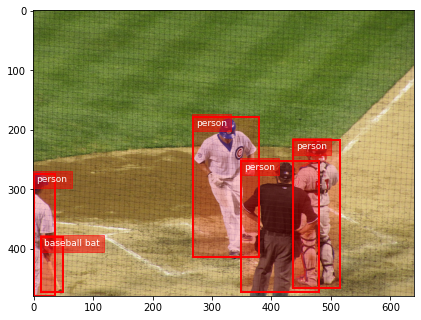

In [22]:
draw_bboxes(img, ann_boxes, verbose=True)

In [23]:
img.shape, ann_boxes.shape

((480, 640, 3), (5, 5))

# TEST: Predict and Non Max Suppresion

<hr style="height: 5px">

In [24]:
image_path = "C:/COCO/images/val2014/COCO_val2014_000000000042.jpg"
image_path = "C:/COCO/images/val2014/COCO_val2014_000000000073.jpg"
image_path = "C:/COCO/images/val2014/COCO_val2014_000000000133.jpg"
image_path = "C:/COCO/images/val2014/COCO_val2014_000000000192.jpg"
image_path = "C:/COCO/images/val2014/COCO_val2014_000000005535.jpg"
image_path = "C:/COCO/images/val2014/COCO_val2014_000000014600.jpg"
image_path = "C:/COCO/images/val2014/COCO_val2014_000000014733.jpg"
# image_path = "C:/COCO/images/val2014/COCO_val2014_000000014921.jpg"
# image_path = "C:/COCO/images/val2014/COCO_val2014_000000014940.jpg"
# image_path = "data/samples/herd_of_horses.jpg"
# image_path = "data/samples/giraffe.jpg"
# image_path = "data/samples/street.jpg"
# image_path = "data/samples/room.jpg"



In [25]:
img = plt.imread(image_path)
try:
    annotation_path = image_path.replace('/images/', '/labels/').replace('.jpg', '.txt')
    ann_boxes = np.loadtxt(annotation_path)
    if len(ann_boxes.shape) == 1:
        ann_boxes = np.expand_dims(ann_boxes,0)
except:
    ann_boxes = None


In [26]:
%%time
outputs = transform_predict(model, img, ann_boxes)
transformed_image = outputs['image']
try:
    targets = outputs['targets'][:, 1:]
    # display(outputs)
except:
    targets = None
    
predicted_bb = non_max_suppression(outputs['predictions'], conf_thres=OBJECT_CONFIDENCE_THRESHOLD, nms_thres=NMS_THRESHOLD)
# predicted_bb

Wall time: 29 ms


In [27]:
# predicted_bb = predict(model, img, ann_boxes)
# print()
# print('Predicted bounding boxes shape:', predicted_bb.shape)
# predicted_bb = non_max_suppression(predicted_bb, conf_thres=OBJECT_CONFIDENCE_THRESHOLD, nms_thres=NMS_THRESHOLD)
# predicted_bb
# # (13*13+26*26+52*52)*3 = 10647
# # (1, 10647, 85)

In [28]:
# transformed_image.shape, targets, predicted_bb, class_names[59]

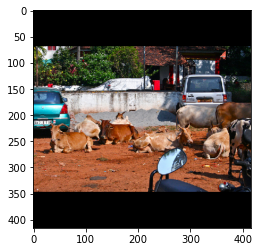

In [29]:
plt.imshow(transformed_image[0].transpose(1,2,0));

Size: (416, 416, 3)


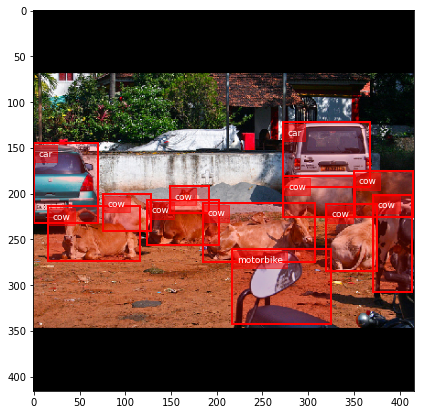

In [30]:
draw_bboxes(#img=img, 
            transformed_image[0].transpose(1,2,0), 
            ann_boxes=targets,
           )


In [31]:
detections = rescale_boxes(predicted_bb, YOLO_IMAGE_SIZE, img.shape[:2])

In [32]:
dd = np.zeros((detections.shape[0], 5))
dd[:,0] = detections[:, 6]
dd[:,1] = (detections[:, 0] + detections[:, 2])/2.0/img.shape[1]
dd[:,2] = (detections[:, 1] + detections[:, 3])/2.0/img.shape[0]
dd[:,3] = (detections[:, 2] - detections[:, 0])/img.shape[1]
dd[:,4] = (detections[:, 3] - detections[:, 1])/img.shape[0]
# dd

Size: (427, 640, 3)


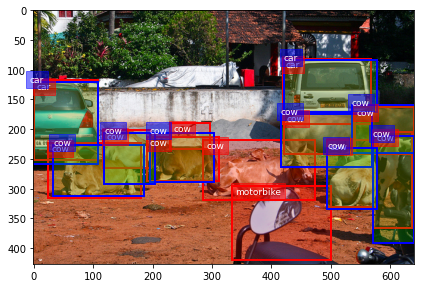

In [33]:
draw_bboxes(img=img, ann_boxes=ann_boxes, pred_boxes=dd)

In [34]:
print('Elapsed time:', dt.datetime.now() - START_TS)

Elapsed time: 0:00:05.942338
